In [1]:
import os
import pickle
import importlib
import numpy as np
from numpy.linalg import qr, solve, norm
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from rossler_map import RosslerMap
from time_series import Rossler_model
from TP import lyapunov_exponent, newton

In [2]:
delta_t = 1e-3
class Feedforward(torch.nn.Module):
    def __init__(self, n_hidden_layers=2, n_neurons=7, hidden_activations=torch.relu,
                 output_activation=None):
        super(Feedforward, self).__init__()
        self.n_layers = n_hidden_layers
        if type(n_neurons) == int:
            self.n_neurons = [3] + [n_neurons for self in range(n_hidden_layers)]
        else:
            assert type(n_neurons) == list
            assert len(n_neurons) == n_hidden_layers
            self.n_neurons = [3] + n_neurons

        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i + 1]
            setattr(self,
                    "layer_{}".format(i + 1),
                    nn.Linear(input_dim, output_dim))

        self.out = nn.Linear(self.n_neurons[-1], 3)

        self.hidden_activations = hidden_activations
        self.output_activation = output_activation

    def forward(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i + 1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
        outputs = self.out(x)
        if self.output_activation is not None:
            outputs = self.output_activation(outputs)
        return outputs.view((-1, 3))


def my_custom_loss(x_pred, x_true, dot_xt_pred, dot_xt_true, delta_t=delta_t):
    loss = nn.functional.l1_loss(dot_xt_true, dot_xt_pred)
    for i in range(len(x_true)):
        loss += 1/(len(x_true) - i)*nn.functional.mse_loss(x_true[i], x_pred[i])
            
    return loss


def train(num_epochs, batch_size, criterion, optimizer, model, dataset, delta_t, display=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (xt, xtp1, xtp2, xtp3, dot_xt, dot_xtp1, dot_xtp2) in train_loader:
            dot_xt_pred = model(xt.float())
            xtp1_pred = xt + dot_xt_pred * delta_t
            
            dot_xtp1_pred = model(xtp1_pred.float())
            xtp2_pred = xtp1 + dot_xtp1_pred * delta_t
            
            dot_xtp2_pred = model(xtp2_pred.float())
            xtp3_pred = xtp2 + dot_xtp2_pred * delta_t
            
            loss = criterion(x_pred=[xtp1_pred, xtp2_pred, xtp3_pred], 
                             x_true=[xtp1, xtp2, xtp3], 
                             dot_xt_true=dot_xt, 
                             dot_xt_pred=dot_xt_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if display:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, epoch_average_loss))
    return train_error


def temporal_derivative(v_t, v_tp1, delta_t):
    return (v_tp1 - v_t) / delta_t


Rossler Map run :

In [3]:
### Build the data and the target trajectory
Niter = int(1e5)
delta_t = 1e-3 # or 1e-2
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
INIT = np.array([-5.75, -1.6,  0.02])
traj, t = ROSSLER_MAP.full_traj(Niter, INIT)
    
traj_t = torch.from_numpy(traj[:-3])
traj_tp1 = torch.from_numpy(traj[1:-2])
traj_tp2 = torch.from_numpy(traj[2:-1])
traj_tp3 = torch.from_numpy(traj[3:])
dot_traj_t = temporal_derivative(traj_t, traj_tp1, delta_t=delta_t)
dot_traj_tp1 = temporal_derivative(traj_tp1, traj_tp2, delta_t=delta_t)
dot_traj_tp2 = temporal_derivative(traj_tp2, traj_tp3, delta_t=delta_t)

training_set = TensorDataset(traj_t, traj_tp1, traj_tp2, traj_tp3,
                             dot_traj_t, dot_traj_tp1, dot_traj_tp2)


### Consider a model to solve our task
model = Feedforward(n_hidden_layers=3, n_neurons=16)
print(model)

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 64

criterion = my_custom_loss # nn.L1Loss() # TO ADAPT

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # TO ADAPT

error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, delta_t=delta_t, display=True)

Feedforward(
  (layer_1): Linear(in_features=3, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=3, bias=True)
)
Epoch [1/30], Loss: 2.3356
Epoch [2/30], Loss: 0.9117
Epoch [3/30], Loss: 0.8562
Epoch [4/30], Loss: 0.8281
Epoch [5/30], Loss: 0.8089
Epoch [6/30], Loss: 0.7926
Epoch [7/30], Loss: 0.7700
Epoch [8/30], Loss: 0.7308
Epoch [9/30], Loss: 0.6608
Epoch [10/30], Loss: 0.5628
Epoch [11/30], Loss: 0.4600
Epoch [12/30], Loss: 0.3826
Epoch [13/30], Loss: 0.3263
Epoch [14/30], Loss: 0.2833
Epoch [15/30], Loss: 0.2494
Epoch [16/30], Loss: 0.2175
Epoch [17/30], Loss: 0.1941
Epoch [18/30], Loss: 0.1764
Epoch [19/30], Loss: 0.1634
Epoch [20/30], Loss: 0.1531
Epoch [21/30], Loss: 0.1448
Epoch [22/30], Loss: 0.1373
Epoch [23/30], Loss: 0.1313
Epoch [24/30], Loss: 0.1260
Epoch [25/30], Loss: 0.1216
Epoch [26/30], Loss: 0.1181
Epoch [27/30], L

In [6]:
### Save our model
main_dir = '../models'
if not os.path.exists(main_dir):
    os.mkdir(main_dir)
model_path = os.path.join(main_dir,'model.pickle')
pickle.dump(model, open(model_path, 'wb'),protocol=4)

In [3]:
main_dir = '../models'
model_path = os.path.join(main_dir,'model_PLS.pickle')
model = pickle.load(open(model_path, 'rb'))
ROSSLER_MAP = RosslerMap(delta_t=delta_t)
print(model)

Feedforward(
  (layer_1): Linear(in_features=3, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=3, bias=True)
)


In [4]:
### Test our model
# Select a new initialization
n_iter_test = 100_000
TEST_INIT = np.array(10*np.random.rand(3)).astype("float32")
trajectory_real, t = ROSSLER_MAP.full_traj(n_iter_test, TEST_INIT)

with torch.no_grad():
    trajectory_simul=[torch.tensor(TEST_INIT).detach().numpy()]

# Predict the next state and add it to the training
print("Generating trajectory from the predicted jacobian...")
with torch.no_grad():
    for k in tqdm(range(n_iter_test-1)):
        x = torch.from_numpy(trajectory_simul[-1])
        dot_x = model(x).squeeze().detach()
        next_x = (x + delta_t * dot_x).detach()
        trajectory_simul.append(next_x.numpy())
trajectory_simul = np.array(trajectory_simul)

Generating trajectory from the predicted jacobian...


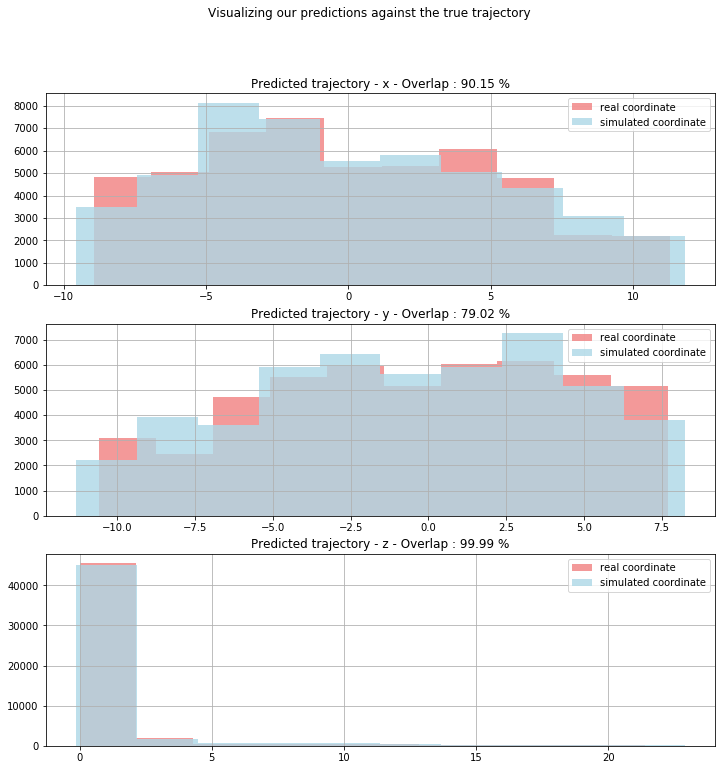

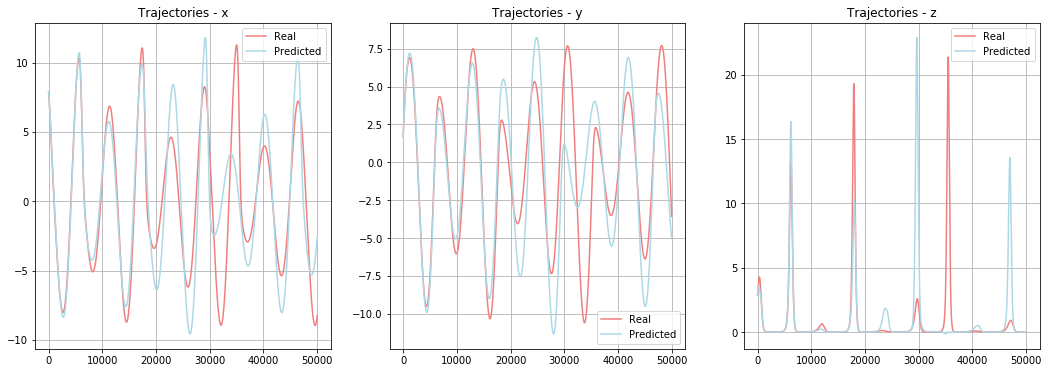

In [5]:
import cv2
def np_hist_to_cv(np_histogram_output):
    counts, bin_edges = np_histogram_output
    return counts.ravel().astype('float32')

# Get the corresponding predicted trajectory over an axis
length = 50_000
# Creates two subplots and unpacks the output array immediately
fig = plt.figure(figsize=(12,12))
for i, name in [(0, 'x'), (1, 'y'), (2, 'z')]:
    
    hist_1 = np.histogram(trajectory_real[:length, i])
    hist_2 = np.histogram(trajectory_simul[:length, i])
    
    correlation = cv2.compareHist(np_hist_to_cv(hist_1), np_hist_to_cv(hist_2), cv2.HISTCMP_CORREL)
    
    fig.suptitle('Visualizing our predictions against the true trajectory')
    plt.subplot(3, 1, i + 1)
    plt.hist(trajectory_real[:length, i], label="real coordinate", color="lightcoral", alpha=0.8)
    plt.hist(trajectory_simul[:length, i], label="simulated coordinate",color="lightblue", alpha=0.8)
    plt.title('Predicted trajectory - {} - Overlap : {:.2f} %'.format(name, correlation*100))
    plt.legend()
    plt.grid()

plt.savefig('Histograms.png')

fig = plt.figure(figsize=(18,6))
for i, name in [(0, 'x'), (1, 'y'), (2, 'z')]:
    ax = plt.subplot(1, 3, i + 1)
    plt.plot(trajectory_real[:length, i], color="lightcoral", label='Real')
    plt.plot(trajectory_simul[:length, i], color="lightblue", label='Predicted')
    plt.title('Trajectories - {}'.format(name))
    plt.legend()
    plt.grid()

plt.savefig('Trajectories.png')

plt.show()

Time series run :

```python
out_dir = '../outputs'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
traj_path = os.path.join(out_dir,'y.tab')

delta_t = 1e-3

ROSSLER = Rossler_model(delta_t, model_path, traj_path)

y = ROSSLER.full_traj()

ROSSLER.save_traj(y)
```

TP main :

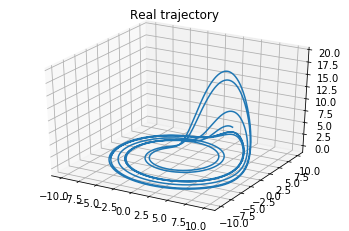

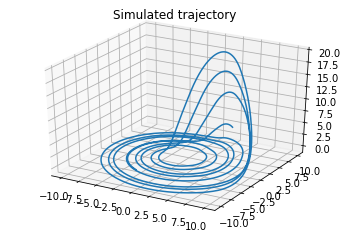

In [14]:
length = 50_000
### Plot both trajectories and get the result
for trajectory, name in [(trajectory_real, "real"), (trajectory_simul, "simulated")]:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(trajectory[:length,0], trajectory[:length,1], trajectory[:length,2])
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    ax.set_zlim(-1, 20)
    ax.set_title("{} trajectory".format(name.title()))
    plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


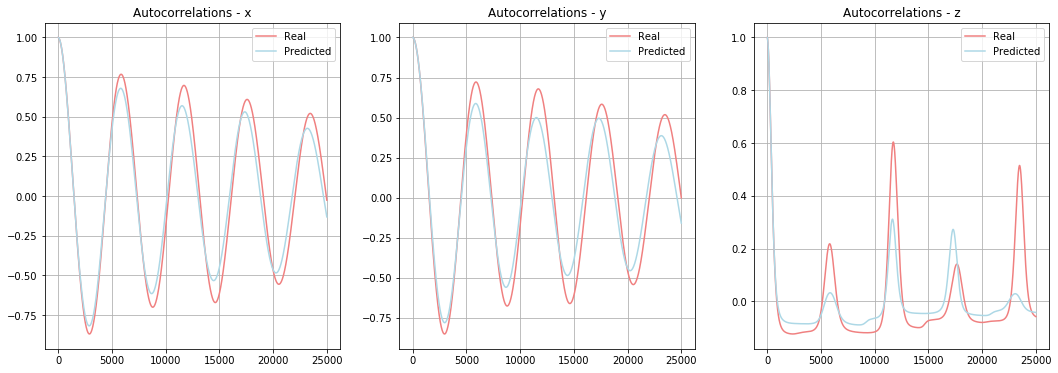

In [15]:
import statsmodels.api
from statsmodels.tsa.stattools import acf

traj_real_x = statsmodels.tsa.stattools.acf(trajectory_real[:length,0],nlags=length//2)
traj_simul_x = statsmodels.tsa.stattools.acf(trajectory_simul[:length,0],nlags=length//2)
traj_real_y = statsmodels.tsa.stattools.acf(trajectory_real[:length,1],nlags=length//2)
traj_simul_y = statsmodels.tsa.stattools.acf(trajectory_simul[:length,1],nlags=length//2)
traj_real_z = statsmodels.tsa.stattools.acf(trajectory_real[:length,2],nlags=length//2)
traj_simul_z = statsmodels.tsa.stattools.acf(trajectory_simul[:length,2],nlags=length//2)



fig = plt.figure(figsize=(18,6))
for i,traj1, traj2, name in [(0,traj_real_x, traj_simul_x, 'x'), (1,traj_real_y, traj_simul_y, 'y'), 
                             (2,traj_real_z, traj_simul_z, 'z')]:
    ax = plt.subplot(1, 3, i + 1)
    plt.plot(traj1, color="lightcoral", label='Real')
    plt.plot(traj2, color="lightblue", label='Predicted')
    plt.title('Autocorrelations - {}'.format(name))
    plt.legend()
    plt.grid()

plt.savefig('Autocorrelations.png')

plt.show()

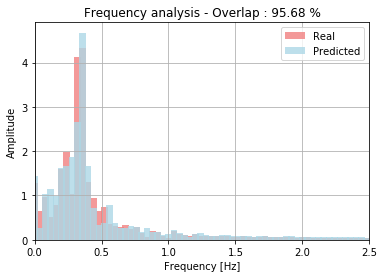

In [31]:
from numpy import fft

fourier_real = np.fft.rfft(trajectory_real[:length,1])
fourier_simul = np.fft.rfft(trajectory_simul[:length,1])

T = delta_t  # sampling interval 
N = fourier_real.size

## 1/T = frequency

f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")

hist_1 = (np.abs(fourier_real)[:N//2] * 1/N, f[:N//2])
hist_2 = (np.abs(fourier_simul)[:N//2] * 1/N, f[:N//2])

correlation = cv2.compareHist(np_hist_to_cv(hist_1), np_hist_to_cv(hist_2), cv2.HISTCMP_CORREL)

plt.bar(f[:N // 2], np.abs(fourier_real)[:N // 2] * 1 / N, width=0.05, color="lightcoral", label='Real', alpha=0.8)  # 1 / N is a normalization factor

plt.bar(f[:N // 2], np.abs(fourier_simul)[:N // 2] * 1 / N, width=0.05, color="lightblue", label='Predicted', alpha=0.8) # 1 / N is a normalization factor

plt.legend()
plt.grid()
plt.title('Frequency analysis - Overlap : {:.2f} %'.format(correlation*100))

plt.xlim(0,2.5)
plt.savefig('frequencies.png')
plt.show()

In [5]:
INIT = np.array([-5.75, -1.6,  0.02])

# Get the real equilibrium point starting from this initialization
fix_point_real = newton(ROSSLER_MAP.v_eq, ROSSLER_MAP.jacobian, INIT)

# We would like to do the same for the predictions but we have to first get the matrix A that corresponds to the NN
model
fix_point_nn = newton(model, INIT)
error = norm(fix_point - ROSSLER_MAP.equilibrium())
print("equilibrium state :", fix_point, ", error : ", error)

lyap = lyapunov_exponent(traj, ROSSLER_MAP.jacobian, max_it=Niter, delta_t=delta_t)
print("Lyapunov Exponents :", lyap, "with delta t =", delta_t)

TypeError: newton() missing 1 required positional argument: 'x'